# Augmentation 적용
## Cutmix VS Mixup

In [1]:
#데이터 준비

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
#GPU 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Dataset
- stanford_dogs 데이터셋에는 120개 견종의 이미지가 포함되어 있으며 총 20,580장의 이미지에서 12,000장은 학습셋, 나머지 8,580장은 평가용 데이터셋임.

In [4]:
import os

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    data_dir = os.getenv('HOME') + '/aiffel/stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised = True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/aiffel/stanford_dogs/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


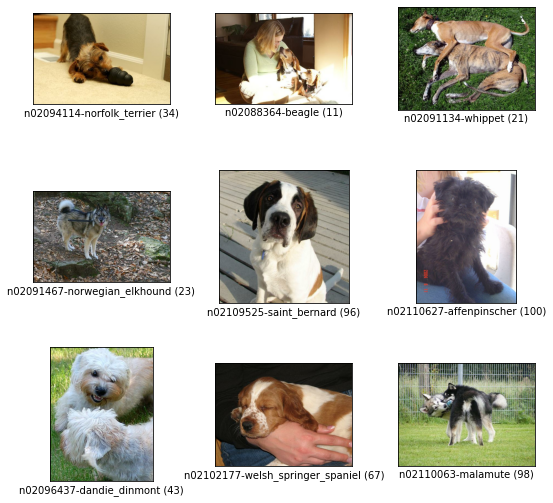

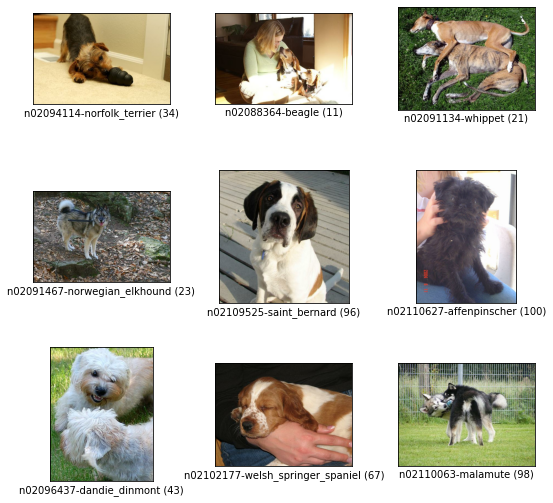

In [5]:
#다운로드 한 데이터 확인
tfds.show_examples(ds_train, ds_info)

In [6]:
#이미지 변환 전처리 함수

def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    
    return tf.cast(image, tf.float32) / 255., label   #normalizing

In [7]:
#Argumentation 적용 - flip,brightness
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    
    return image, label

In [9]:
#Argumentation 랜덤하게 적용
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    
    return image, label

In [8]:
#Augmentation을 통해 원본 데이터셋에 다양한 형태의 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현한 메인 함수
#일반적인 전처리 과정인 normalize, resize, augmentation과 shuffle을 적용.
#shuffle이나 augmentation은 테스트 데이터셋에는 적용하지 않아야 함!!!

#with_aug 매개변수를 통해 augmentation의 적용여부를 결정.
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  #기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       #augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

### Augmentation 적용 - 비교 실험
-  텐서플로우 케라스의 ResNet50 중 imagenet으로 훈련된 모델 사용

In [10]:
num_classes = ds_info.features["label"].num_classes

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,   #include_top은 마지막 fully connected layer를 포함할지 여부
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94773248/94765736 [==============================] - 2s 0us/step


- inclued_top은 마지막 fully connected layer를 포함할지말지 결정하는 것.
- 해당 레이어를 포함하지 않고 생성하면 특성 추출기(feature extractor) 부분만 불러와 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있음.
- 이미지넷(ImageNet)과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수) 또한 다르기 때문에 이렇게 해 줘야 함.

In [11]:
#Augmentation을 적용한 데이터셋으로 학습시킬 ResNet
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

- 텐서플로우 데이터셋에서 불러온 데이터에 하나는 apply_normalize_on_dataset()에서 with_aug를 False로 주어 augmentation이 적용되지 않도록 하고, 다른 하나는 True로 주어 augmentation이 적용되도록 함.

In [12]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    data_dir = os.getenv('HOME') + '/aiffel/stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [13]:
#Augentation 적용 효과를 확인하기 위해 필요한 epoch 수는 최소 20임.
#에폭 20으로 진행 시 GPu 기반으로 3-4시간 시간 소요됨.

#여기선 시간 관계상 5로 진행함.
EPOCH = 5

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
750/750 [==============================] - 365s 445ms/step - loss: 3.1884 - accuracy: 0.2776 - val_loss: 3.7110 - val_accuracy: 0.1616
Epoch 2/5
750/750 [==============================] - 338s 451ms/step - loss: 0.9235 - accuracy: 0.7432 - val_loss: 1.2066 - val_accuracy: 0.6560
Epoch 3/5
750/750 [==============================] - 339s 452ms/step - loss: 0.3485 - accuracy: 0.9159 - val_loss: 0.9603 - val_accuracy: 0.7141
Epoch 4/5
750/750 [==============================] - 339s 452ms/step - loss: 0.0957 - accuracy: 0.9871 - val_loss: 0.9157 - val_accuracy: 0.7359
Epoch 5/5
750/750 [==============================] - 339s 452ms/step - loss: 0.0346 - accuracy: 0.9979 - val_loss: 0.9302 - val_accuracy: 0.7393
Epoch 1/5
750/750 [==============================] - 348s 454ms/step - loss: 3.2408 - accuracy: 0.2697 - val_loss: 2.8995 - val_accuracy: 0.2846
Epoch 2/5
750/750 [==============================] - 339s 453ms/step - loss: 1.0825 - accuracy: 0.6955 - val_loss: 1.1690 - val_ac

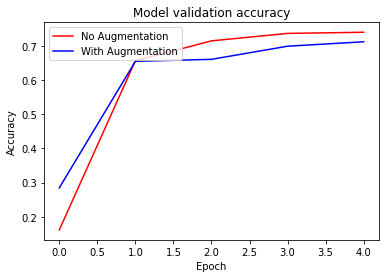

In [14]:
#훈련과정 시각화
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

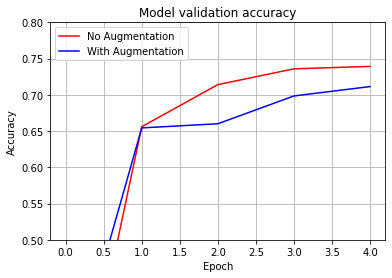

In [16]:
#확대 한 시각화
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    #출력하고자 하는  Accuracy 범위를 지정해야함. 
#plt.ylim(0.72, 0.76)  #EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

## Cutmix
- 이미지 데이터를 자르고 섞는 것.
- Mixup은 특정 비율로 픽셀별 값을 섞는 방식이고, Cutout은 이미지를 잘라내는 방식.
- CutMix는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법으로 이미지를 섞는 부분과 섞은 이미지에 맞추어 라벨을 섞는 부분을 포함함.

### - 이미지 섞기
- 두 개의 이미지를 섞을건데 배치 내의 이미지를 두개 골라서 섞을 것.
- 이미지에서 잘라서 섞어주는 영역을 바운딩 박스(bounding box)라고 부름.
- 바운딩 박스의 위치를 랜덤하게 뽑고 이를 잘라 두 개의 이미지를 섞는 함수를 만들 것.
- 이미지를 텐서로 만들어서 텐서플로우 연산을 사용할 것.
- 이미지는 tfds에서 한 장 뽑아서 사용.

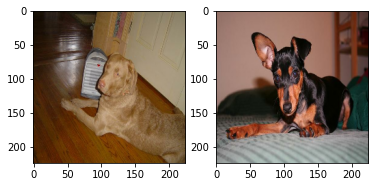

In [17]:
import matplotlib.pyplot as plt

#데이터셋에서 이미지 2개를 가져옴. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

- 첫 번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두 번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수를 구현할 것.
- width, height가 다르더라도 가변적으로 적용할 수 있도록 구현되어 있으므로 임의의 이미지 사이즈에 대해서도 대응 가능하도록 함수를 구현할 것.

In [18]:
#바운딩 박스 위치 결정하는 함수
def get_clip_box(image_a, image_b):
    
    #image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    #get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    #get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    #clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(150, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(162, shape=(), dtype=int32)


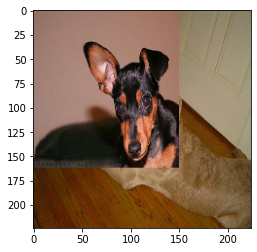

In [19]:
#바운딩 박스의 각 영역을 가져와 합치는 함수
#mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    # mage_b의 왼쪽 바깥 영역
    middle_left = image_a[y_min:y_max, 0:x_min, :] 
    
    # image_b의 안쪽 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  
    
    # image_b의 오른쪽 바깥 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] 
    
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)

plt.imshow(mixed_img.numpy())
plt.show()

### - 라벨 섞기
- 이미지를 섞었으니 라벨도 이에 맞게 섞어줘야 함.
- CutMix에서는 면적에 비례해서 라벨을 섞어 줌.
- 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더해줌.
- 라벨 벡터는 보통 클래스를 표시하듯 클래스 1개만 1의 값을 가지는 원-핫 인코딩이 아니라 A와 B 클래스에 해당하는 인덱스에 각각 0.4, 0.6을 배분하는 방식을 사용함.

In [20]:
#mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.51570475, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [21]:
#배치 단위의 cutmix() 함수
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

## Mixup
- 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식.
- 두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어줌.

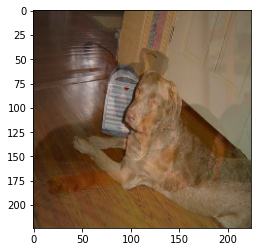

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.78557014 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.21442986 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [22]:
#mixup 함수
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)

plt.imshow(mixed_img.numpy())
plt.show()

print(mixed_label)

In [23]:
#배치단위의 mixup() 함수
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels